![Unidata organization logo](https://github.com/Unidata/metpy-ams-2023/raw/main/logos/unidata_logo_horizontal.png)
# Exploring MetPy
> As atmospheric scientists, you view, analyze, and synthesize a multitude of datasets every day. 
> These data and model output are collected by numerous entities and are stored in disparate locatons. 
> Luckily, we have access to the THREDDS catalog which nicely aggregates and organizes that data for us.
> Using MetPy, we can programmatically access, analyze, and display those data for our specific needs on demand. 

## Table of Contents <a class="anchor" id="top"></a>

* [Objective](#objective)
* [Strategy](#strategy)
* [0: Import required packages](#step0)
* [1: Browse the THREDDS Data Server (TDS)](#step1)
* [2: Satellite data](#step2)
    * [2a: Obtain Satellite data](#step2a)
    * [2b: Prepare Satellite data](#step2b)
    * [2c: Visualize Satellite data](#step2c)
* [3: Gridded data](#step3)
    * [3a: Obtain Gridded Data](#step3a)
    * [3b: Prepare Gridded Data](#step3b)
    * [3c: Visualize Gridded Data](#step3c)

## Objective
Today, you will explore a few of the many uses of MetPy by creating a multi-layer plot like this one. Plots like these are ubiquitous in research, forecasting, and education. 

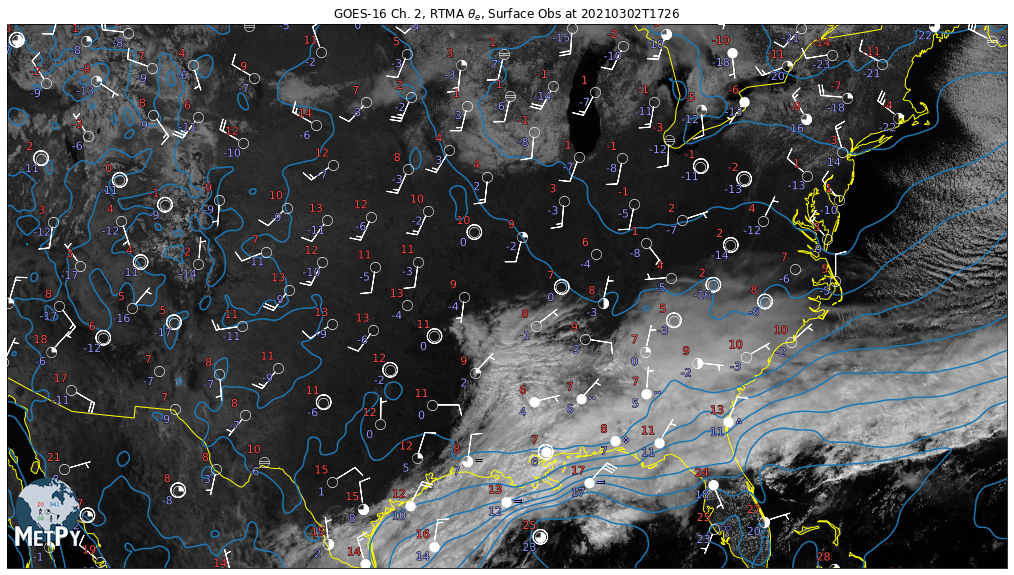

## Strategy <a class="anchor" id="strategy"></a>
Creating plots like this using MetPy follows this workflow:

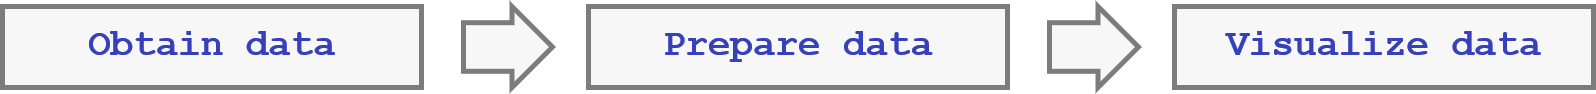

## Step 0: Import required packages <a class="anchor" id="step0"></a>
[Top](#top)  
But first, we need to import all our required packages. Today we're working with:
- datetime
- numpy
- io
- cartopy
- matplotlib
- metpy
- siphon

In [1]:
from datetime import datetime
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# We will use the standard "plt" abbreviation to access matplotlib
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke

import metpy.calc as mpcalc
import metpy.plots as mpplots

from metpy.io import parse_metar_file
from metpy.units import pandas_dataframe_to_unit_arrays

# Here is where we import the TDSCatalog class from siphon for obtaining our data 
from siphon.catalog import TDSCatalog

## Step 1: Browse the THREDDS Data Server (TDS) <a class="anchor" id="step1"></a>
[Top](#top)

The **THREDDS Data Server** provides us with coherent access to a large collection of real-time and archived datasets from a variety of environmental data sources at a number of distributed server sites. 
You can browse the TDS in your web browser using this link: <a href="https://thredds.ucar.edu/" target ="blank">https://thredds.ucar.edu/</a>


## Step 2: Satellite Data <a class="anchor" id="step2"></a>
[Top](#top)  


The first layer we will obtain is satellite imagery. To do this, we will create a THREDDS Data Server (TDS) catalog object, then extract a single image with its metadata, and visualize the result in a simple plot. For these tasks, we will leverage xarray to store the data in memory.  

<div>
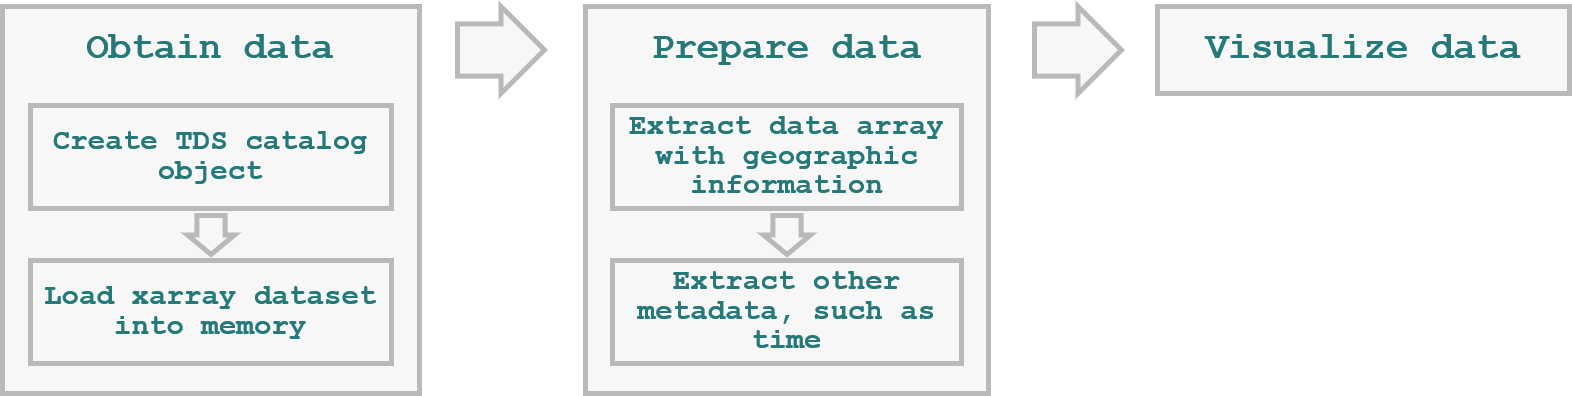
</div>

### Step 2a: Obtain Satellite Data <a class="anchor" id="step2a"></a>
[Top](#top)

We will use siphon's TDSCatalog object to create a catalog of satellite data from the TDS that match our criteria (the most recent GOES East, cloud and moisture imagery, CONUS extent, channel 2 data).  

Then we use siphon's remote_access method to read in the most recent satellite image from the catalog into an xarray Dataset. 


<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
    Notice the URL in the TDSCatalog input ends with .xml rather than .html. While your web browser uses html to show you the data in a human-friendly webpage, siphon requires an xml document to create the TDSCatalog object.
</div>


In [2]:
# Create TDS catalog object
satcat = TDSCatalog(
    "https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel02/current/catalog.xml"
)

# satcat includes many images as a part of the catalog
# choose the first (most recent) image in the catalog, index = 0
satdata = satcat.datasets[0].remote_access(use_xarray=True)

### Step 2b: Prepare Satellite Data <a class="anchor" id="step2b"></a>
[Top](#top)

Next, we'll pull the satellite image (as an xarray DataArray) from satdata (an xarray Dataset) using the <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.xarray.html#metpy.xarray.MetPyDatasetAccessor.parse_cf" target="blank">metpy `parse_cf` method </a>with the variable name *"Sectorized_CMI"* as input. 

Using the datetime package, we'll extract the *"start_date_time"* attribute from satdata. GOES East stores data in julian days (year, day of the year, hours, minutes, seconds). 

In [3]:
# extract the DataArray 
cmi = satdata.metpy.parse_cf("Sectorized_CMI")

# extract the date and time
dt = datetime.strptime(satdata.attrs["start_date_time"], "%Y%j%H%M%S")

### Step 2c: Visualize Satellite Data <a class="anchor" id="step2c"></a>
[Top](#top)

Now that we have the data ready, it's time to **plot**. Incrementally plotting data is considered a best practice for understanding the data you are working with and determining if you are on your way to creating your intended product.
<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Plot CMI</p>
    To plot this image, we will use <b>matplotlib</b> to display our data. Let's first make sure we have the information we need: <br> 
<ul>
    <li>What is the name of the dataarray variable we need to plot?</li>
    <li>What is the matplotlib function to use?</li>
    <li>What is the correct syntax for using the function?</li>
</ul>
</div>




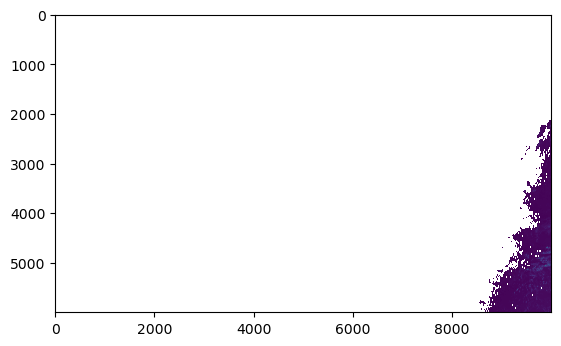

In [4]:
# ACTIVITY: Plot CMI 
# Create your plot code below



## INSTRUCTOR'S ANSWER KEY ## 
plt.imshow(cmi)

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Challenge: Plot CMI</p>
    Using the matplotlib documentation as a reference, change the color map of your above plot to grayscale <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="blank">https://matplotlib.org/stable/tutorials/colors/colormaps.html</a>
</div>

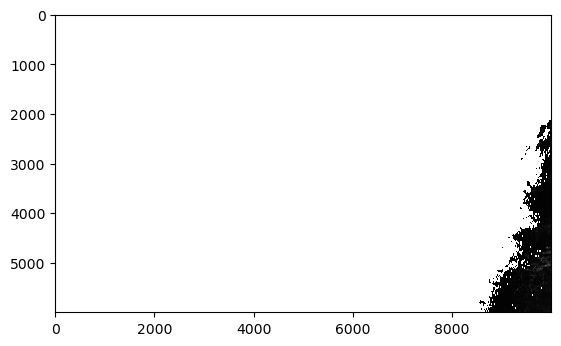

In [5]:
# CHALLENGE: Plot CMI




## INSTRUCTOR'S ANSWER KEY ## 
plt.imshow(cmi, cmap="Greys_r")

## Step 3: Model output, equivalent potential temperature ($\theta_e$) <a class="anchor" id="step3"></a>
[Top](#top)


Now we grab data from the Real-time Meso-analysis (RTMA), which gives us a gridded estimate of the realtime conditions. Our goal is to use MetPy to calculate <a href="https://glossary.ametsoc.org/wiki/Equivalent_potential_temperature" target="blank">equivalent potential temperature ($\theta_e$)</a>, using the fields we have available in the RTMA. 

This time we will also add some additional detail to our intermediate plot. To provide geographic reference, we will plot with a geographic projection and add coastlines. 

<div>
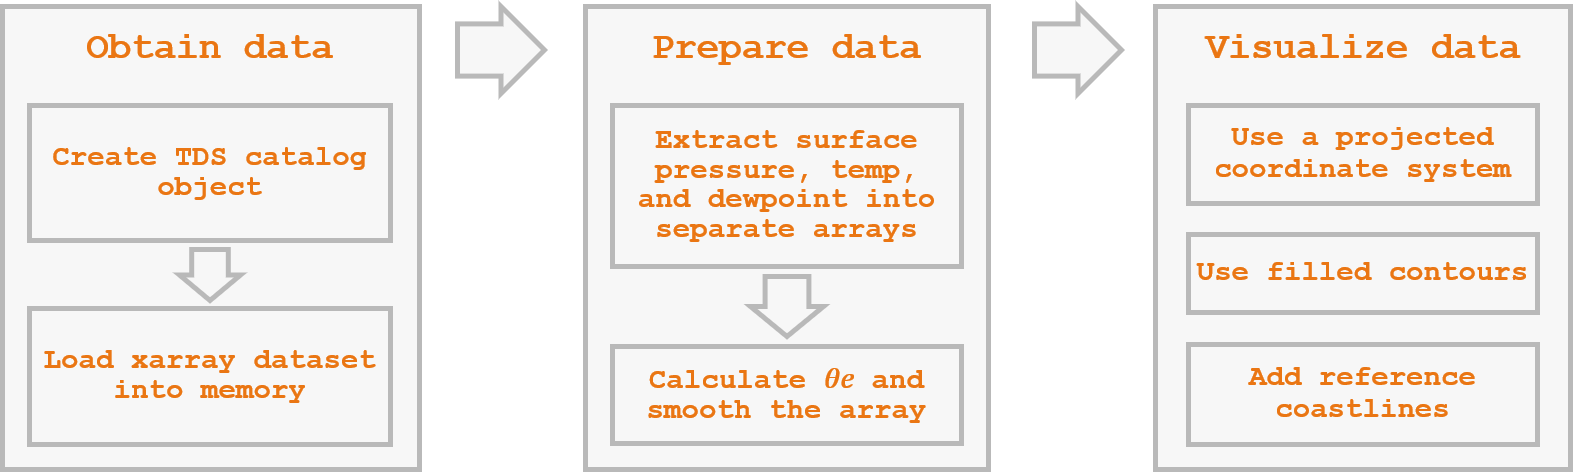
</div>

### Step 3a: Obtain Model Output <a class="anchor" id="step3a"></a>
[Top](#top)

Using similar methods as above, we 
1. Create a TDSCatalog object of the data we specify (RTMA output over the CONUS extent).
2. Pull the Full Collection Dataset into an in-memory xarray Dataset.
3. Parse dataset for coordinate system metadata according to CF conventions.

In [6]:
# Again using Siphon, get the full collection of RTMA 
# data opened using xarray.
rtma_cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xml')
rtma_data = rtma_cat.datasets['Full Collection (Reference / Forecast Time) Dataset'].remote_access(use_xarray=True)
rtma_data = rtma_data.metpy.parse_cf()

### Step 3b: Prepare Model Output <a class="anchor" id="step3b"></a>
[Top](#top)

Before we calculate any derived variables, we need to look up the required input variables. Looking at the metpy.calc documentation for <a href ="https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.equivalent_potential_temperature.html#metpy.calc.equivalent_potential_temperature" target="blank">equivalent potential temperature</a>, we can see that this function requires three variables: surface pressure, temperature, and dewpoint. Each of these variables are contained in our rtma_data Dataset, but we need to know what variable name each are stored under. 


<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Find RTMA Variable Names</p>
    <code>rtma_data</code> is an xarray Dataset containing several variables. Use the cell below to programmatically display the list of all variables in the Dataset, then find the names of the <b>surface pressure</b>, <b>temperature</b>, and <b>dewpoint</b> variables. 
</div>


In [7]:
# ACTIVITY: Find RTMA Variable Names




## INSTRUCTOR'S ANSWER KEY ##
# Recall from prework
# Have learner share in chat window
# NOTE: without using print, errors may come up accessing one specific variable before the variable list is displayed
print(rtma_data)

<xarray.Dataset>
Dimensions:                                                              (
                                                                          timeOffset: 1,
                                                                          : 2,
                                                                          reftime: 728,
                                                                          x: 2145,
                                                                          y: 1377,
                                                                          validtime1Offset: 1,
                                                                          height_above_ground: 1,
                                                                          height_above_ground1: 1,
                                                                          altitude_above_msl: 1)
Coordinates:
  * timeOffset                                                           (timeOffset

Surface pressure is stored in the *"Pressure_Analysis_surface"* variable name. We'll use this to select the DataArray within that variable at the time closest to that of the satellite image (at time = `dt`). Here we use the <a href="http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html" target="blank">xarray `sel` method</a>. 

Notice the use of the `squeeze()` method. This helps eliminate any stray dimensions for the vertical since we want a 2D array as output (some values are at a particular height, like 2 m, rather than the surface).

In [8]:
# Store the surface pressure DataArray to variable `pres`
pres = rtma_data.Pressure_Analysis_surface.sel(reftime=dt, method='nearest').squeeze()

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Create Temperature and Dewpoint DataArrays</p>
    Using the information from the previous activity and following the demonstration in the previous cell, create <code>temp</code> and <code>dewp</code> variables that represent the surface temperature and dewpoint, respectively. 
</div>

In [9]:
# ACTIVITY: Create Temperature and Dewpoint DataArrays

# temp = 
# dewp = 


## INSTRUCTOR'S ANSWER KEY ##
temp = rtma_data.Temperature_Analysis_height_above_ground.sel(reftime=dt, method='nearest').squeeze()
dewp = rtma_data.Dewpoint_temperature_Analysis_height_above_ground.sel(reftime=dt, method='nearest').squeeze()


We can use MetPy shortcuts to create a cartopy <a href="https://scitools.org.uk/cartopy/docs/latest/crs/index.html#cartopy.crs.CRS">cartographic reference system</a> for our data. RTMA uses a Lambert Conformal projection, which we will use in our final multi-layer plot. This is our final data preparation step for the `theta_e` DataArray. 

In [10]:
# Create the crs object for the theta_e array
rtma_crs = temp.metpy.cartopy_crs

### Step 3c: Visualize Model Output <a class="anchor" id="step3c"></a>
[Top](#top)


The data are now prepared for plotting. Let's now use a different plotting technique, **filled contours**, for visualizing the $\theta_e$ field. Let's also reproject the DataArray onto a **Robinson** projection, and add cartopy's built-in `coastlines` class for geographic context.  

/Users/dcamron/mambaforge/envs/metpy-ams-2023/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/dcamron/mambaforge/envs/metpy-ams-2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


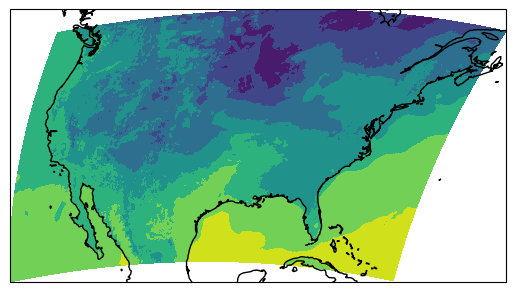

In [11]:
# Create figure, axes, then use contourf to create filled contours of the theta_e field
fig = plt.figure()
ax = fig.add_subplot(projection=ccrs.Robinson())
ax.contourf(temp['x'], temp['y'], temp, transform=rtma_crs)
ax.coastlines()

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Tip</p>
    If you are working with xarray DataArrays parsed via <code>metpy.parse_cf</code>, and you aren't sure what your horizontal variables (e.g. x, or lon, or latitude) are named, or you just want a shortcut, you can access these quickly with <code>xarray.metpy.x</code> and <code>xarray.metpy.y</code>.<br><br>For example, these two lines of code are equivalent for DataArrays parsed with <code>metpy.parse.cf</code>:<br><br>
    <code>ax.contourf(temp['x'], temp['y'], temp, transform=rtma_crs)</code><br>
    <code>ax.contourf(temp.metpy.x, temp.metpy.y, temp, transform=rtma_crs)</code>
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Contour plots</p>
    To work towards a multi-layered plot, you will now do the following:<br>
    <ol>
    <li>Plot <code>temp</code> using the <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html" target="blank">matplotlib <code>contour()</code> plot type</a>.</li>
    <li>Use the LambertConformal projection in your axes, the same projection the RTMA dataset uses.</li>
    <li>Add coastlines.</li>
    <li>Make the contours a single color (<a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html" target="blank">see examples here</a>).</li>
    <li>Add a descriptive title to your plot.</li>
    </ol>
    After you have created the <code>temp</code> plot, you are free to create more contour plots of other RTMA variables you have explored in this notebook. Choose any colors, but label your plots with titles that describe the variable(s) plotted. 

</div>


In [12]:
# ACTIVITY: Contour plots




## INSTRUCTOR'S ANSWER KEY ##
#ax = plt.axes(projection=rtma_crs)
#ax.contour(temp.metpy.x, temp.metpy.y, temp, transform=rtma_crs, colors='blue')
#ax.coastlines()